# Defining subdomains for different materials
Author: Jørgen S. Dokken

Solving PDEs in domains made up of different materials is a frequently encountered task. In FEniCSx, we handle these problems by defining a Discontinous cell-wise constant function.
Such a function can be created over any mesh in the following way
## Subdomains on built-in meshes

In [2]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, assemble_scalar,
                         form, locate_dofs_geometrical, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import create_unit_square, locate_entities
from dolfinx.plot import vtk_mesh

from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner)

from mpi4py import MPI

import meshio
import gmsh
import numpy as np
import pyvista

#pyvista.start_xvfb()

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)
Q = functionspace(mesh, ("DG", 0))

We will use a simple example with two materials in two dimensions to demonstrate the idea. The whole domain will be $\Omega=[0,1]\times[0,1]$, which consists of two subdomains
$\Omega_0=[0,1]\times [0,1/2]$ and $\Omega_1=[0,1]\times[1/2, 1]$. We start by creating two python functions, where each returns `True` if the input coordinate is inside its domain.

In [91]:
def Omega_0(x):
    return x[1] <= 0.5

def Omega_1(x):
    return x[1] >= 0.8

In [92]:
print(np.isclose(x[1], 0))

[False  True  True]


Note that both functions use a $\leq$ or $\geq$, as FEniCSx will evaluate each cell at all of the vertices, and thus has to return `True` for all vertices aligned with the interface to be marked properly.

We will solve a variable-coefficient extension of the Poisson equation

$$
-\nabla \cdot [\kappa (x,y)\nabla u(x, y)]= 1 \qquad \text{in } \Omega,
$$
$$
u=u_D=1 \qquad \text{on } \partial\Omega_D=[0,y], y\in[0,1]
$$
$$
-\frac{\partial u}{\partial n}=0 \qquad \text{on } \partial\Omega\setminus \partial\Omega_D
$$

Our next step is to define $\kappa$

In [93]:
kappa = Function(Q)
cells_0 = locate_entities(mesh, mesh.topology.dim, Omega_0)
cells_1 = locate_entities(mesh, mesh.topology.dim, Omega_1)

In the previous code block, we found which cells (triangular elements) satisfy the condition for being in $\Omega_0, \Omega_1$. As the $DG-0$ function contains only one degree of freedom per cell, there is a one to one mapping between the cell indicies and the degrees of freedom. We let $\kappa=\begin{cases}
1 &\text{if } x\in\Omega_0\\
0.1& \text{if } x\in\Omega_1\\
\end{cases}$

In [94]:
kappa.x.array[cells_0] = np.full_like(cells_0, 1, dtype=default_scalar_type)
kappa.x.array[cells_1] = np.full_like(cells_1, 0.1, dtype=default_scalar_type)

We are now ready to define our variational formulation and  Dirichlet boundary condition after using integration by parts

In [95]:
V = functionspace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)
a = inner(kappa * grad(u), grad(v)) * dx
x = SpatialCoordinate(mesh)
L = Constant(mesh, default_scalar_type(1)) * v * dx
dofs = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
bcs = [dirichletbc(default_scalar_type(1), dofs, V)]

We can now solve and visualize the solution of the problem

In [102]:
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Filter out ghosted cells
tdim = mesh.topology.dim
num_cells_local = mesh.topology.index_map(tdim).size_local
marker = np.zeros(num_cells_local, dtype=np.int32)
cells_0 = cells_0[cells_0 < num_cells_local]
cells_1 = cells_1[cells_1 < num_cells_local]
marker[cells_0] = 1
marker[cells_1] = 2
mesh.topology.create_connectivity(tdim, tdim)
topology, cell_types, x = vtk_mesh(mesh, tdim, np.arange(num_cells_local, dtype=np.int32))

p = pyvista.Plotter(window_size=[800, 800])
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
grid.cell_data["Marker"] = marker
grid.set_active_scalars("Marker")
p.add_mesh(grid, show_edges=True)
if pyvista.OFF_SCREEN:
    figure = p.screenshot("subdomains_structured.png")
p.show()

Widget(value='<iframe src="http://localhost:59285/index.html?ui=P_0x2ccaf6570_24&reconnect=auto" class="pyvist…

In [78]:
p2 = pyvista.Plotter(window_size=[800, 800])
grid_uh = pyvista.UnstructuredGrid(*vtk_mesh(V))
grid_uh.point_data["u"] = uh.x.array.real
grid_uh.set_active_scalars("u")
p2.add_mesh(grid_uh, show_edges=True)
if not pyvista.OFF_SCREEN:
    p2.show()
else:
    figure = p2.screenshot("subdomains_structured2.png")

Widget(value='<iframe src="http://localhost:59285/index.html?ui=P_0x2b86dd040_15&reconnect=auto" class="pyvist…

We clearly observe different behavior in the two regions, which both have the same Dirichlet boundary condition on the left side, where $x=0$.

## Interpolation with Python-function
As we saw in the first approach, in many cases, we can use the geometrical coordinates to determine which coefficient we should use. Using the unstructured mesh from the previous example, we illustrate an alternative approach using interpolation:

In [8]:
def eval_kappa(x):
    values = np.zeros(x.shape[1], dtype=default_scalar_type)
    # Create a boolean array indicating which dofs (corresponding to cell centers)
    # that are in each domain
    top_coords = x[1] > 0.5
    bottom_coords = x[1] < 0.5
    values[top_coords] = np.full(sum(top_coords), 0.1)
    values[bottom_coords] = np.full(sum(bottom_coords), 1)
    return values

In [9]:
kappa2 = Function(Q)
kappa2.interpolate(eval_kappa)

We verify this by assembling the error between this new function and the old one

In [10]:
# Difference in kappa's
error = mesh.comm.allreduce(assemble_scalar(form((kappa - kappa2)**2 * dx)))
print(error)

0.0


## Subdomains defined from external mesh data
Let us now consider the same problem, but using GMSH to generate the mesh and subdomains. We will then in turn show how to use this data to generate discontinuous functions in DOLFINx.

In [11]:
gmsh.initialize()
proc = MPI.COMM_WORLD.rank
top_marker = 2
bottom_marker = 1
left_marker = 1
if proc == 0:
    # We create one rectangle for each subdomain
    gmsh.model.occ.addRectangle(0, 0, 0, 1, 0.5, tag=1)
    gmsh.model.occ.addRectangle(0, 0.5, 0, 1, 0.5, tag=2)
    # We fuse the two rectangles and keep the interface between them
    gmsh.model.occ.fragment([(2, 1)], [(2, 2)])
    gmsh.model.occ.synchronize()

    # Mark the top (2) and bottom (1) rectangle
    top, bottom = None, None
    for surface in gmsh.model.getEntities(dim=2):
        com = gmsh.model.occ.getCenterOfMass(surface[0], surface[1])
        if np.allclose(com, [0.5, 0.25, 0]):
            bottom = surface[1]
        else:
            top = surface[1]
    gmsh.model.addPhysicalGroup(2, [bottom], bottom_marker)
    gmsh.model.addPhysicalGroup(2, [top], top_marker)
    # Tag the left boundary
    left = []
    for line in gmsh.model.getEntities(dim=1):
        com = gmsh.model.occ.getCenterOfMass(line[0], line[1])
        if np.isclose(com[0], 0):
            left.append(line[1])
    gmsh.model.addPhysicalGroup(1, left, left_marker)
    gmsh.model.mesh.generate(2)
    gmsh.write("mesh.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00120559s, CPU 0.001918s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00843314s, CPU 0.008966s)
Info    : 103 nodes 218 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'


## Read in MSH files with DOLFINx
You can read in MSH files with DOLFINx, which will read them in on a single process, and then distribute them over the available ranks in the MPI communicator.

In [12]:
mesh, cell_markers, facet_markers = gmshio.read_from_msh("mesh.msh", MPI.COMM_WORLD, gdim=2)

Info    : Reading 'mesh.msh'...
Info    : 15 entities
Info    : 103 nodes
Info    : 180 elements
Info    : Done reading 'mesh.msh'


## Convert msh-files to XDMF using meshio
We will use `meshio` to read in the `msh` file, and convert it to a more suitable IO format. Meshio requires `h5py`, and can be installed on linux with the following commands:
```{code}
export HDF5_MPI="ON"
export CC=mpicc
export HDF5_DIR="/usr/lib/x86_64-linux-gnu/hdf5/mpich/"
pip3 install --no-cache-dir --no-binary=h5py h5py meshio
```
We start by creating a convenience function for extracting data for a single cell type, and creating a new `meshio.Mesh`.

In [13]:
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read": [cell_data.astype(np.int32)]})
    return out_mesh

This function returns a meshio mesh, including physical markers for the given type. The `prune_z` argument is for cases where we want to use two dimensional meshes. The last coordinate in the mesh (as it is generated in a 3D space) has to be removed for DOLFINx to consider this as a two dimensional geometry.

In [14]:
if proc == 0:
    # Read in mesh
    msh = meshio.read("mesh.msh")

    # Create and save one file for the mesh, and one file for the facets
    triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
    line_mesh = create_mesh(msh, "line", prune_z=True)
    meshio.write("mesh.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
MPI.COMM_WORLD.barrier()

We have now written the mesh and the cell markers to one file, and the facet markers in a separate file. We can now read this data in DOLFINx using `XDMFFile.read_mesh` and `XDMFFile.read_meshtags`. The `dolfinx.MeshTags` stores the index of the entity, along with the value of the marker in two one dimensional arrays.

Note that we have generated and written the mesh on only one processor. However, the `xdmf`-format supports parallel IO, and we can thus read the mesh in parallel.

In [15]:
with XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

We have now read in the mesh and corresponding cell and facet data. We can now create our discontinuous function `kappa` as follows

In [16]:
Q = functionspace(mesh, ("DG", 0))
kappa = Function(Q)
bottom_cells = ct.find(bottom_marker)
kappa.x.array[bottom_cells] = np.full_like(bottom_cells, 1, dtype=default_scalar_type)
top_cells = ct.find(top_marker)
kappa.x.array[top_cells] = np.full_like(top_cells, 0.1, dtype=default_scalar_type)

We can also efficiently use the facet data `ft` to create the Dirichlet boundary condition

In [17]:
V = functionspace(mesh, ("Lagrange", 1))
u_bc = Function(V)
left_facets = ft.find(left_marker)
mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
left_dofs = locate_dofs_topological(V, mesh.topology.dim - 1, left_facets)
bcs = [dirichletbc(default_scalar_type(1), left_dofs, V)]

We can now solve the problem in a similar fashion as above

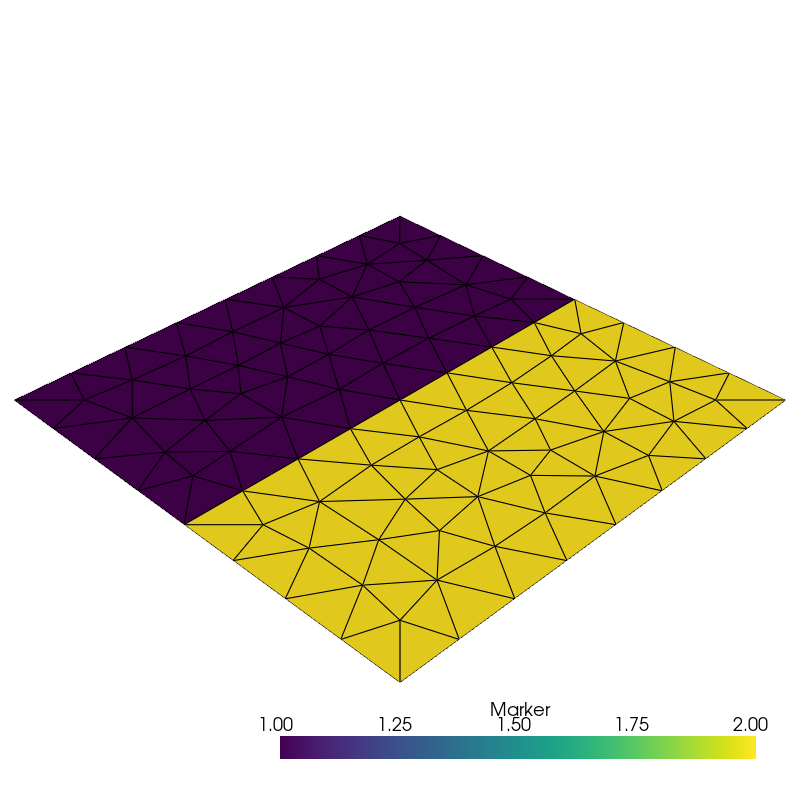

In [18]:
u, v = TrialFunction(V), TestFunction(V)
a = inner(kappa * grad(u), grad(v)) * dx
x = SpatialCoordinate(mesh)
L = Constant(mesh, default_scalar_type(1)) * v * dx

problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# As the dolfinx.MeshTag contains a value for every cell in the
# geometry, we can attach it directly to the grid

tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, tdim)
topology, cell_types, x = vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
num_local_cells = mesh.topology.index_map(tdim).size_local
grid.cell_data["Marker"] = ct.values[ct.indices < num_local_cells]
grid.set_active_scalars("Marker")

p = pyvista.Plotter(window_size=[800, 800])
p.add_mesh(grid, show_edges=True)
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure = p.screenshot("subdomains_unstructured.png")

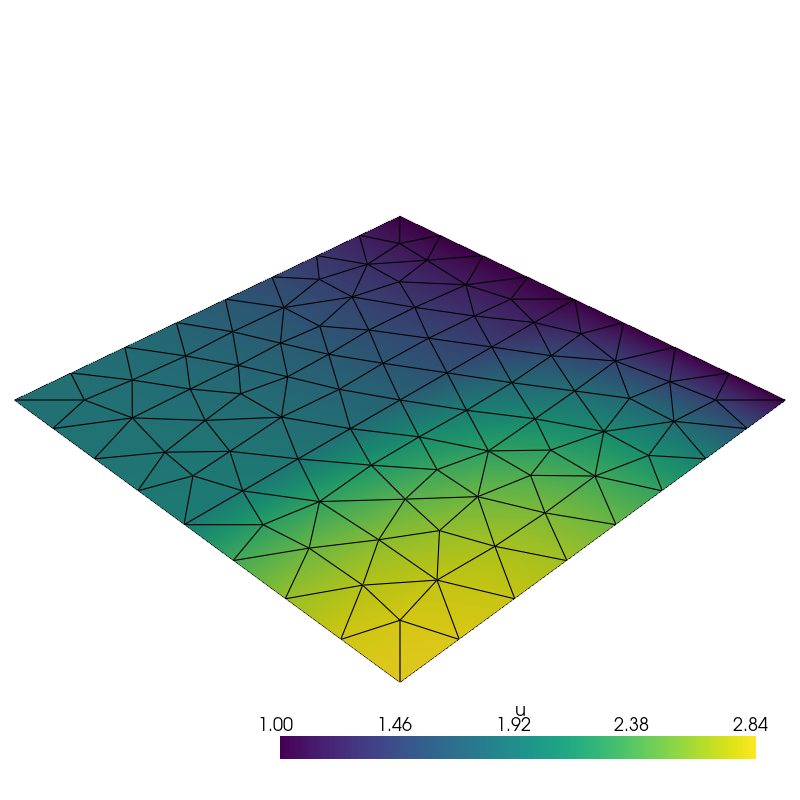

In [19]:
grid_uh = pyvista.UnstructuredGrid(*vtk_mesh(V))
grid_uh.point_data["u"] = uh.x.array.real
grid_uh.set_active_scalars("u")
p2 = pyvista.Plotter(window_size=[800, 800])
p2.add_mesh(grid_uh, show_edges=True)
if not pyvista.OFF_SCREEN:
    p2.show()
else:
    p2.screenshot("unstructured_u.png")